I'll follow classification process with https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/examples/notebooks/TripletMarginLossMNIST.ipynb

In [1]:
import time
import logging 

import torch
import torch.nn as nn

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, distances, testers, reducers
from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.98


_____

In [2]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [3]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # embedding + averaging
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return embedded
    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
def train(cur_epoch, dataloader, mining_func):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        embeddings = model(text, offsets)        
        indices_tuple = mining_func(embeddings, label)
        loss = loss_func(embeddings, label, indices_tuple)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
    print("Current Epoch {} : Loss = {}, Number of mined triplets = {}".format(cur_epoch, loss, mining_func.num_triplets))

def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def evaluate(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

____

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('.data/DBpedia/train.csv')
test_df = pd.read_csv('.data/DBpedia/test.csv')
valid_df = pd.read_csv('.data/DBpedia/valid.csv')

In [7]:
label_dict = {v:k for k,v in enumerate(train_df['l3'].unique())}

In [8]:
train_iter = iter(list(zip(train_df['l3'].map(lambda x : label_dict[x]).tolist(), train_df['text'].tolist())))

____

In [9]:
tokenizer = get_tokenizer('basic_english')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

# set vocab size
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

cuda


In [10]:
# load nn.Module object
# train_iter = AG_NEWS(split='train')
train_iter = iter(list(zip(train_df['l3'].tolist(), train_df['text'].tolist())))
num_class = len(set([label for (label, text) in train_iter])); print(num_class)
vocab_size = len(vocab); print(vocab_size)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

219
628321


In [11]:
train_iter = iter(list(zip(train_df['l3'].map(lambda x : label_dict[x]).tolist(), train_df['text'].tolist())))
valid_iter = iter(list(zip(valid_df['l3'].map(lambda x : label_dict[x]).tolist(), valid_df['text'].tolist())))
test_iter = iter(list(zip(test_df['l3'].map(lambda x : label_dict[x]).tolist(), test_df['text'].tolist())))

In [12]:
EPOCHS = 50 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_iter)
valid_dataset = to_map_style_dataset(valid_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

### generate out of distribution

______

In [13]:
### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 20)

In [14]:
num_epochs = 20 # epoch

for epoch in range(1, num_epochs+1):
    train(epoch, train_dataloader, mining_func)
    evaluate(train_dataloader, test_dataloader, model, accuracy_calculator)

Current Epoch 1 : Loss = 0.08876243233680725, Number of mined triplets = 47
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.7240517156298318
Current Epoch 2 : Loss = 0.08275283873081207, Number of mined triplets = 8
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.7821331052406487
Current Epoch 3 : Loss = 0.103387750685215, Number of mined triplets = 44
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8088298187321117
Current Epoch 4 : Loss = 0.11704577505588531, Number of mined triplets = 16
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8304437937954403
Current Epoch 5 : Loss = 0.08505919575691223, Number of mined triplets = 4
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.842435108727835
Current Epoch 6 : Loss = 0.0930502638220787, Number of mined triplets = 41
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8518274829752936
Current Epoch 7 : Loss = 0.06205897778272629, Number of mined triplets = 7
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8568115274533671
Current Epoch 8 : Loss = 0.07919204235076904, Number of mined triplets = 8
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8640655327828404
Current Epoch 9 : Loss = 0.10284100472927094, Number of mined triplets = 2
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8679639438102444
Current Epoch 10 : Loss = 0.04561801627278328, Number of mined triplets = 7
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8731947231634701
Current Epoch 11 : Loss = 0.04102347791194916, Number of mined triplets = 2
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8763858275487713
Current Epoch 12 : Loss = 0.02756526879966259, Number of mined triplets = 5
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8811560351350463
Current Epoch 13 : Loss = 0.03927801549434662, Number of mined triplets = 5
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8820607296772708
Current Epoch 14 : Loss = 0.07949498295783997, Number of mined triplets = 7
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8849722012040662
Current Epoch 15 : Loss = 0.03984899818897247, Number of mined triplets = 1
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8866664473467777
Current Epoch 16 : Loss = 0.12090273201465607, Number of mined triplets = 1
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8886074283646412
Current Epoch 17 : Loss = 0.0800723284482956, Number of mined triplets = 2
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8919301246833569
Current Epoch 18 : Loss = 0.10481341183185577, Number of mined triplets = 1
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8906800013159193
Current Epoch 19 : Loss = 0.08748984336853027, Number of mined triplets = 13
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8931637990591177
Current Epoch 20 : Loss = 0.11713214218616486, Number of mined triplets = 2
Computing accuracy


INFO:root:running k-nn with k=20
INFO:root:embedding dimensionality is 32


Test set accuracy (Precision@1) = 0.8942494325097872


____

In [15]:
from cycler import cycler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [16]:
model.fc = Identity()

In [17]:
def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

In [18]:
label_mapper = {v:k for k,v in label_dict.items()}

In [19]:
# test dataset (same dataset)
embeddings, labels = get_all_embeddings(test_dataloader, model)
tsne_embeddings = TSNE(2).fit_transform(embeddings)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

dict_ = dict()

for l in torch.unique(labels) : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    dict_[l] = np.nanmean(cs_mat)

pd.DataFrame.from_dict(dict_, orient='index').describe()

,0
count,219.000000
mean,0.724721
std,0.088779
min,0.396010
25%,0.681850
50%,0.735302
75%,0.791016
max,0.917192


# Full Visualization

<BarContainer object of 219 artists>

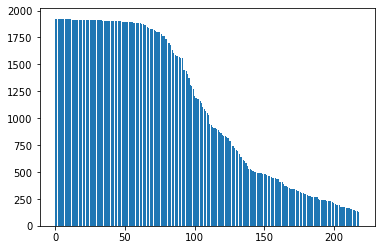

In [22]:
plt.bar(range(train_df.l3.unique().shape[0]), train_df.l3.value_counts().values)

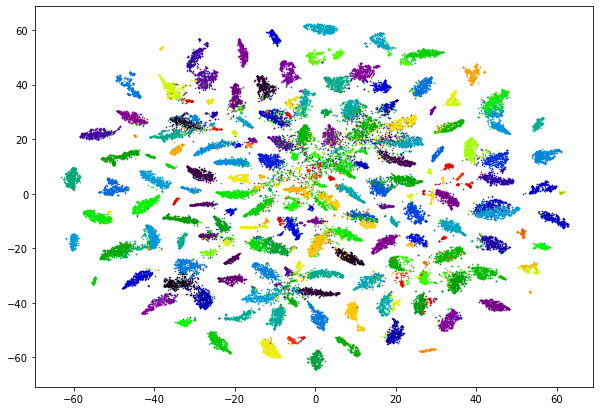

In [23]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=1, label=str_label)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

# Imbalance Visualization

In [63]:
small_labels = [label_dict[l] for l in train_df.l3.value_counts().tail(30).index]

In [64]:
mem = []

for l in small_labels : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    mem.append(np.nanmean(cs_mat))

(array([2., 3., 5., 4., 4., 7., 1., 3., 0., 1.]),
 array([0.4518773 , 0.49840873, 0.5449402 , 0.5914716 , 0.63800305,
        0.68453443, 0.73106587, 0.7775973 , 0.82412875, 0.8706602 ,
        0.9171916 ], dtype=float32),
 <BarContainer object of 10 artists>)

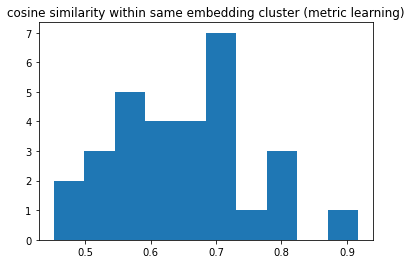

In [68]:
plt.title("cosine similarity within same embedding cluster (metric learning)")
plt.hist(mem)

In [70]:
cs_mat = cosine_similarity(embeddings[np.in1d(labels, small_labels)])
cs_mat[np.tril_indices_from(cs_mat)] = np.nan

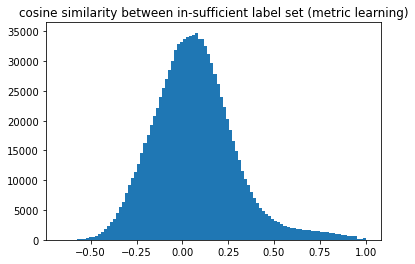

In [71]:
plt.title("cosine similarity between in-sufficient label set (metric learning)")
_ = plt.hist(cs_mat[np.isfinite(cs_mat)], bins=100)

In [72]:
cs_mat = cosine_similarity(embeddings[~np.in1d(labels, small_labels)], \
                  embeddings[np.in1d(labels, small_labels)].mean(0).reshape(1,-1))


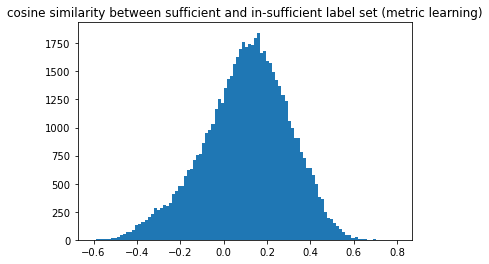

In [74]:
plt.title("cosine similarity between sufficient and in-sufficient label set (metric learning)")
_ = plt.hist(cs_mat[np.isfinite(cs_mat)], bins=100)

In [26]:
markersize = 5

In [ ]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, len(small_labels))]))
for i in small_labels :
    idx = labels == label_set[i]
    str_label = label_mapper[label_set[i]]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize, label=str_label)
# plt.legend()
plt.show()

# Out of distribution visualization

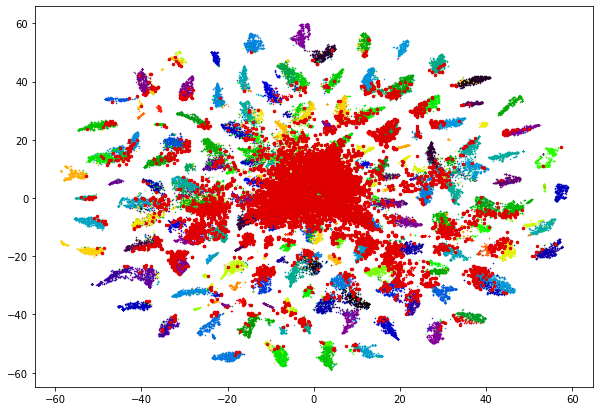

In [60]:
label_set = np.unique(cat_labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) \
                                          for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes) :
    idx = cat_labels == label_set[i]
    markersize = 5 if label_set[i] >= 1000 else 1
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize)
# plt.legend()
plt.show()